Melbourne Housing Analysis

0) Описание задачи

Датасет о недвижимости Мельбурна, содержащий сведения о продаже домов и квартир.
Каждый объект характеризуется рядом признаков — количеством комнат, площадью участка, годом постройки, количеством ванных,
географическим положением (широта/долгота), расстоянием до центра и т.д. Целевая переменная — **Price**, то есть цена продажи.

Требуется построить предсказательную модель, которая на основе характеристик объекта недвижимости сможет
оценивать его цену. Это задача регрессии, где требуется аппроксимировать зависимость `Price = f(признаки)`.

Признаки:

* Rooms: Number of rooms

- Price: Цена в долларах

- Method: S — имущество продано; SP — имущество продано ранее; PI — имущество передано; PN — продано ранее, цена не разглашается; SN — продано, цена не разглашается; NB — ставка не сделана; VB — ставка продавца; W — отозвано до аукциона; SA — продано после аукциона; SS — продано после аукциона, цена не разглашается. N/A — цена или максимальная ставка недоступны.

- Type: br — спальня(и); h — дом, коттедж, вилла, полудом, терраса; u — квартира, дуплекс; t — таунхаус; dev site — участок под застройку; o res — другое жилое помещение.

- SellerG: агент по недвижимости

- Date: дата продажи

- Distance: расстояние от центрального делового района

- Regionname: общий регион (Запад, Северо-Запад, Север, Северо-Восток и т. д.)

- Propertycount: количество объектов недвижимости в пригороде.

- Bedroom2 : количество спален (из другого источника)

- Bathroom: количество ванных комнат

- Car: количество парковочных мест

- Landsize: площадь участка

- BuildingArea: площадь застройки

- CouncilArea: площадь муниципального образования


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dansbecker/melbourne-housing-snapshot")
path += "/melb_data.csv"
df = pd.read_csv(path)

Using Colab cache for faster access to the 'melbourne-housing-snapshot' dataset.


In [3]:
Q1, Q3 = df['Price'].quantile([.25, .75])
IQR = Q3 - Q1
price_lower = Q1 - 1.5*IQR
price_upper = Q3 + 1.5*IQR
Q1, Q3 = df['BuildingArea'].quantile([.25, .75])
IQR = Q3 - Q1
area_lower = Q1 - 1.5*IQR
area_upper = Q3 + 1.5*IQR
rows_to_drop = df[
    (df['Price'] < price_lower) | (df['Price'] > price_upper) |
    (df['BuildingArea']  < area_lower)  | (df['BuildingArea']  > area_upper)].index
df_km = df.drop(rows_to_drop)

num_cols = df_km.select_dtypes(include=np.number).columns.tolist()
for col in num_cols:
    df_km[col] = df_km[col].fillna(df_km[col].median())

cat_cols = df_km.select_dtypes(include=["object"]).columns.tolist()
for col in cat_cols:
    df_km[col] = df_km[col].fillna(df_km[col].mode()[0])

# Преобразование даты
df_km["Date"] = pd.to_datetime(df_km["Date"], dayfirst = True)

df_km["Year"]      = df_km["Date"].dt.year
df_km["Month"]     = df_km["Date"].dt.month
df_km["DayOfYear"] = df_km["Date"].dt.dayofyear
df_km["DaysSince"] = (df_km["Date"] - df_km["Date"].min()).dt.days

df_km = df_km.drop(columns=["Date"])
cat_cols.remove("Date")
ohe_cols = []
freq_cols = []

for c in cat_cols:
    nunique = df_km[c].nunique()
    if nunique <= 10:
        ohe_cols.append(c)
    else:
        freq_cols.append(c)


for col in freq_cols:
    freq_map = df_km[col].value_counts(normalize=True)
    df_km[col] = df_km[col].map(freq_map)


df_km = pd.get_dummies(df_km, columns=ohe_cols, drop_first=True)

if "Price" in df_km.columns:
    df_km = df_km.drop(columns=["Price"])


In [4]:
scaler = StandardScaler()
df_km_scaled = pd.DataFrame(
    scaler.fit_transform(df_km),
    columns=df_km.columns,
    index=df_km.index
)

df_km_scaled.head()

,Suburb,Address,Rooms,SellerG,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,...,Method_SA,Method_SP,Method_VB,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria
0,-0.659727,-0.164349,-0.946491,-0.473675,-1.300287,-0.401766,-0.910482,-0.758319,-0.605848,-0.212371,...,-0.083356,-0.385364,-0.303711,-0.061466,1.531785,-0.055385,-0.188367,-0.690948,-0.539976,-0.050155
1,-0.659727,-0.164349,-0.946491,-0.473675,-1.300287,-0.401766,-0.910482,-0.758319,-1.673765,-0.243918,...,-0.083356,-0.385364,-0.303711,-0.061466,1.531785,-0.055385,-0.188367,-0.690948,-0.539976,-0.050155
2,-0.659727,10.925327,0.145574,-0.473675,-1.300287,-0.401766,0.167240,0.851074,-1.673765,-0.259006,...,-0.083356,2.594952,-0.303711,-0.061466,1.531785,-0.055385,-0.188367,-0.690948,-0.539976,-0.050155
3,-0.659727,-0.164349,0.145574,-0.473675,-1.300287,-0.401766,0.167240,0.851074,-0.605848,-0.286438,...,-0.083356,-0.385364,-0.303711,-0.061466,1.531785,-0.055385,-0.188367,-0.690948,-0.539976,-0.050155
4,-0.659727,-0.164349,1.237640,1.734617,-1.300287,-0.401766,0.167240,-0.758319,0.462069,-0.268607,...,-0.083356,-0.385364,3.292602,-0.061466,1.531785,-0.055385,-0.188367,-0.690948,-0.539976,-0.050155


In [ ]:
def plot_clusters(labels, X, title):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    unique_labels = np.unique(labels)
    n_clusters = len([c for c in unique_labels if c != -1])
    cmap = plt.get_cmap("tab20", n_clusters)

    plt.figure(figsize=(8, 6))

    for cluster_id in unique_labels:
        if cluster_id == -1:
            # цвет для шума
            color = "black"
        else:
            color = cmap(cluster_id % n_clusters)

        plt.scatter(
            X_pca[labels == cluster_id, 0],
            X_pca[labels == cluster_id, 1],
            s=12,
            color=color,
            label=f"Кластер {cluster_id}",
            alpha = 0.5
        )

    plt.title(title)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend()
    plt.show()


DBSCAN: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(-1)}


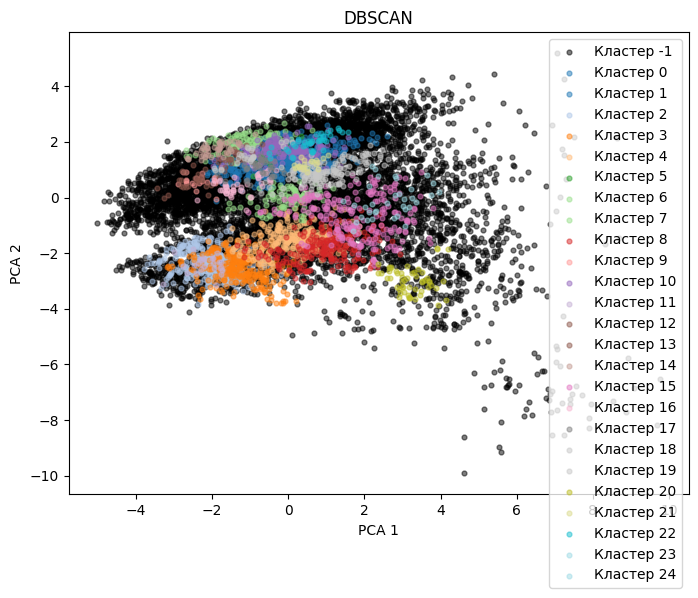

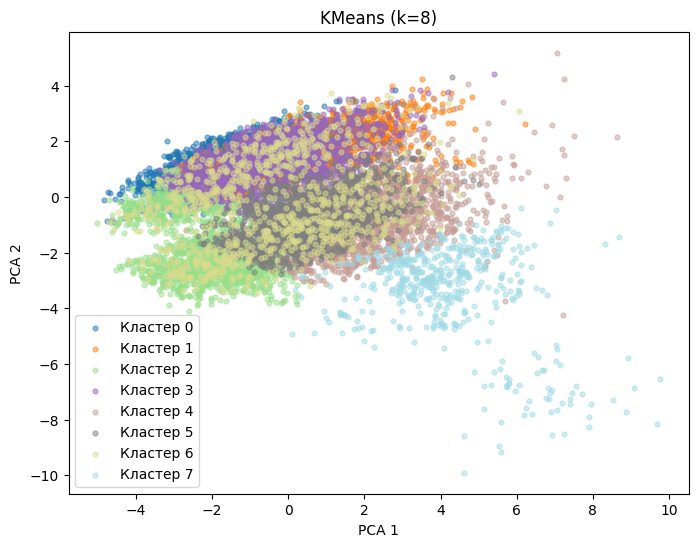

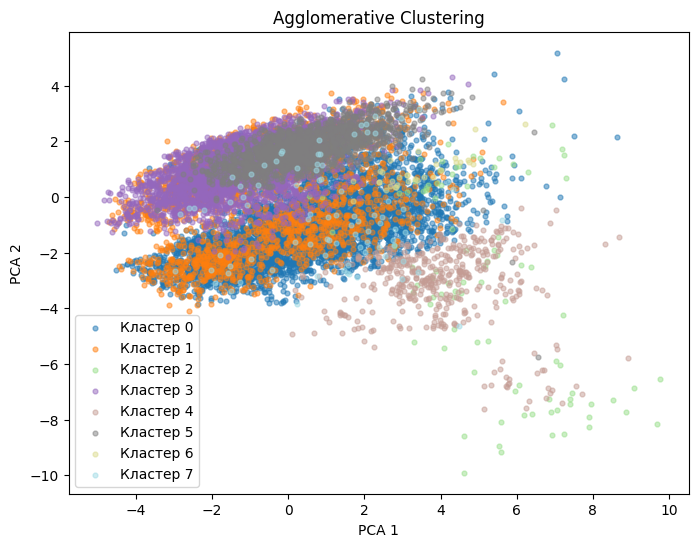

In [ ]:
#Вариант 1 кластеризации
dbscan = DBSCAN(eps=2, min_samples=20)
labels_dbscan = dbscan.fit_predict(df_km_scaled)
print("DBSCAN:", set(labels_dbscan))
plot_clusters(labels_dbscan, df_km_scaled, "DBSCAN")

k = 8
kmeans = KMeans(n_clusters=k, random_state=42)
labels_kmeans = kmeans.fit_predict(df_km_scaled)
plot_clusters(labels_kmeans, df_km_scaled, f"KMeans (k={k})")

agg = AgglomerativeClustering(n_clusters=k)
labels_agg = agg.fit_predict(df_km_scaled)
plot_clusters(labels_agg, df_km_scaled, "Agglomerative Clustering")

DBSCAN: {np.int64(0), np.int64(1), np.int64(2), np.int64(-1)}


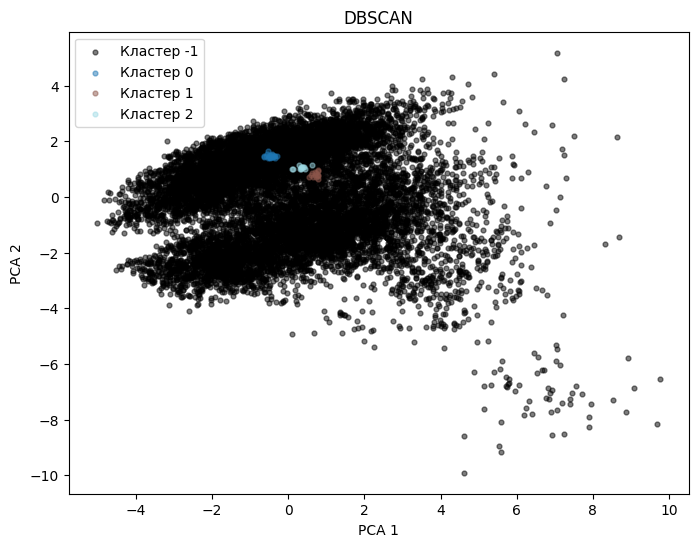

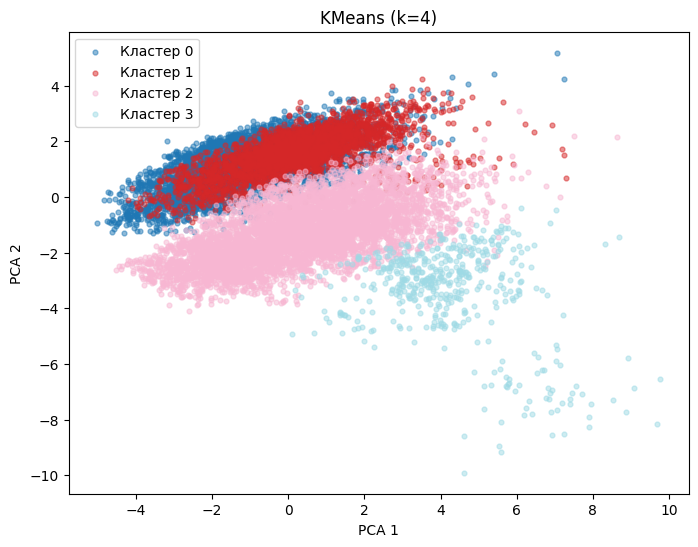

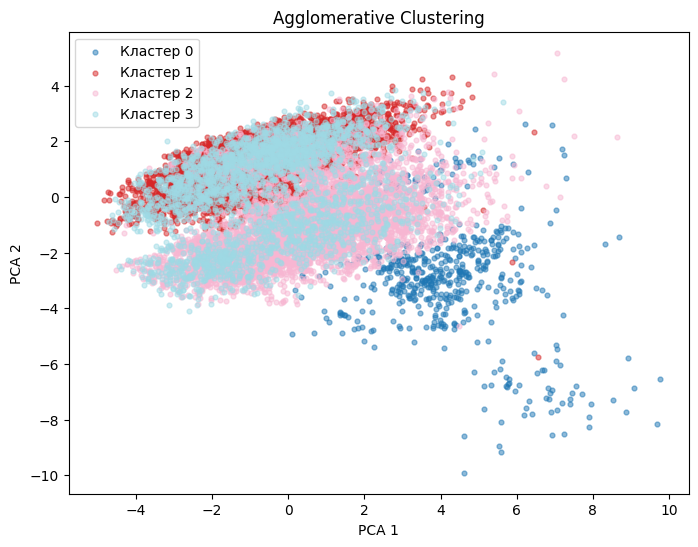

In [ ]:
#Вариант 2 кластеризации с другими гиперпараметрами методов
dbscan = DBSCAN(eps=1, min_samples=10)
labels_dbscan = dbscan.fit_predict(df_km_scaled)
print("DBSCAN:", set(labels_dbscan))
plot_clusters(labels_dbscan, df_km_scaled, "DBSCAN")

k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
labels_kmeans = kmeans.fit_predict(df_km_scaled)
plot_clusters(labels_kmeans, df_km_scaled, f"KMeans (k={k})")

agg = AgglomerativeClustering(n_clusters=k)
labels_agg = agg.fit_predict(df_km_scaled)
plot_clusters(labels_agg, df_km_scaled, "Agglomerative Clustering")

DBSCAN: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(-1)}


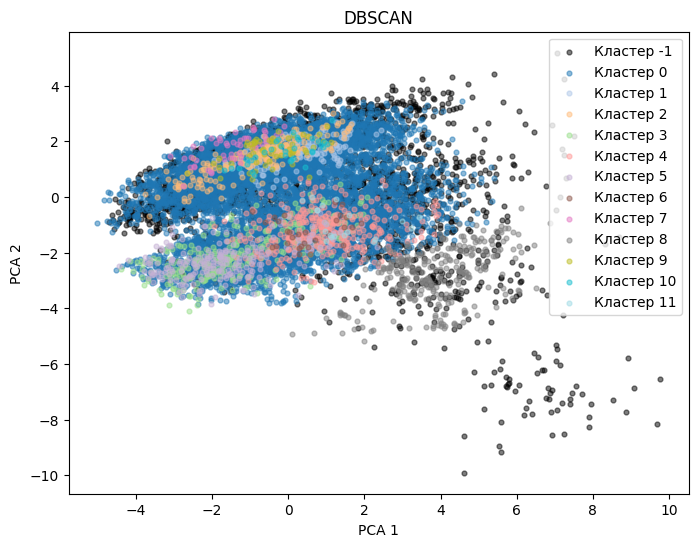

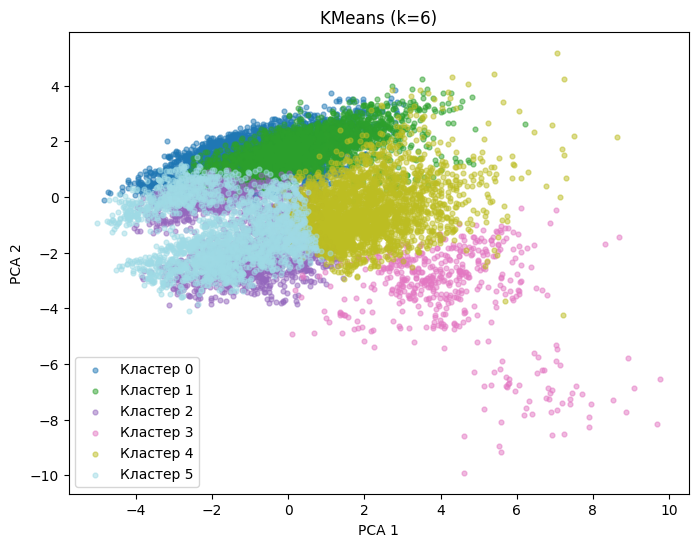

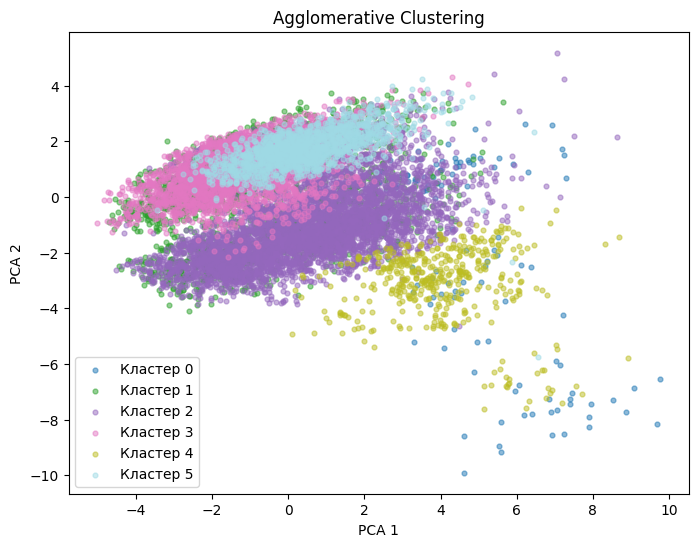

In [ ]:
#Итоговая кластеризация
dbscan = DBSCAN(eps=3, min_samples=20)
labels_dbscan = dbscan.fit_predict(df_km_scaled)
print("DBSCAN:", set(labels_dbscan))
plot_clusters(labels_dbscan, df_km_scaled, "DBSCAN")

k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
labels_kmeans = kmeans.fit_predict(df_km_scaled)
plot_clusters(labels_kmeans, df_km_scaled, f"KMeans (k={k})")

agg = AgglomerativeClustering(n_clusters=k)
labels_agg = agg.fit_predict(df_km_scaled)
plot_clusters(labels_agg, df_km_scaled, "Agglomerative Clustering")

In [ ]:
#Подбор гиперпараметров для DBSCAN
for eps in [0.5, 1.0, 1.5, 2.0, 3.0]:
    for ms in [5, 10, 20]:
        labels = DBSCAN(eps=eps, min_samples=ms).fit_predict(df_km_scaled)
        print(f"eps={eps}, min_samples={ms}, clusters={set(labels)}")


eps=0.5, min_samples=5, clusters={np.int64(0), np.int64(-1)}
eps=0.5, min_samples=10, clusters={np.int64(-1)}
eps=0.5, min_samples=20, clusters={np.int64(-1)}
eps=1.0, min_samples=5, clusters={np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(-1)}
eps=1.0, min_samples=10, clusters={np.int64(0), np.int64(1), np.int64(2), np.int64(-1)}
eps=1.0, min_samples=20, clusters={np.int64(-1)}
eps=1.5, min_samples=5, clusters={np.int64(0), np.

# Выводы
Нетрудно видеть, что алгоритм DBSCAN сильно зависит от выбора своих гиперпараметров, в первую очередь параметров eps и min_samples. При неудачном подборе параметров модель выделяет либо слишком много кластеров, либо почти весь датасет относит к шуму (label = -1). Это связано с тем, что исходные данные имеют высокую размерность и относительно неравномерную плотность, что делает DBSCAN менее устойчивым.

Даже при оптимальных значениях гиперпараметров, когда количество кластеров и объём шума оказываются разумными, PCA-визуализация показывает заметное пересечение кластеров и слабое их разделение. Это может свидетельствовать либо о том, что PCA не полностью сохраняет структуру плотностей, либо, что вероятнее, о том, что DBSCAN не подходит для данного датасета.

KMeans и агломеративная класретизация ведут себя более предсказуемо. С увеличением числа кластеров они последовательно уточняют разбиение пространства признаков, но сильнее пересеаются.

При сравнении визуализаций можно заметить, что агломеративная кластеризация даёт более смешанные кластеры, которые сильнее накладываются друг на друга в 2D-проекции PCA. А KMeans формирует более компактные и чётко выраженные группы, что делает результаты визуально и концептуально более понятными.

Таким образом, для данного датасета:

- DBSCAN работает хуже остальных методов из-за неоднородной плотности данных и высокой размерности признакового пространства.

- Agglomerative Clustering показывает приемлемый результат, но кластеры заметно пересекаются.

- KMeans оказывается самым устойчивым и интерпретируемым алгоритмом: кластеры более компактны и лучше разделяются в PCA-пространстве.

Поэтому KMeans можно считать наиболее подходящим методом кластеризации для рассматриваемого набора данных.